# Clustering - Customer Segmentation

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, isnull
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

In [2]:
spark = SparkSession.builder \
    .appName("Clustering") \
    .getOrCreate()

25/01/27 11:49:04 WARN Utils: Your hostname, Adams-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 172.20.10.10 instead (on interface en0)
25/01/27 11:49:04 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/27 11:49:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/01/27 11:49:04 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/01/27 11:49:04 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


## Load data

In [3]:
data_path = "/Users/ssyan110/Codes/Big_data_in_machine_learning/Final/Data/CC_GENERAL.csv"
data = spark.read.csv(data_path, header=True, inferSchema=True)

In [4]:
data.show(5)

+-------+-----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+-----------+----------------+----------------+------+
|CUST_ID|    BALANCE|BALANCE_FREQUENCY|PURCHASES|ONEOFF_PURCHASES|INSTALLMENTS_PURCHASES|CASH_ADVANCE|PURCHASES_FREQUENCY|ONEOFF_PURCHASES_FREQUENCY|PURCHASES_INSTALLMENTS_FREQUENCY|CASH_ADVANCE_FREQUENCY|CASH_ADVANCE_TRX|PURCHASES_TRX|CREDIT_LIMIT|   PAYMENTS|MINIMUM_PAYMENTS|PRC_FULL_PAYMENT|TENURE|
+-------+-----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+-----------+----------------+----------------+------+
| C10001|  40.900749|         0.818182|     95.4|             0.0|                  95.4|  

In [5]:
data.printSchema()

root
 |-- CUST_ID: string (nullable = true)
 |-- BALANCE: double (nullable = true)
 |-- BALANCE_FREQUENCY: double (nullable = true)
 |-- PURCHASES: double (nullable = true)
 |-- ONEOFF_PURCHASES: double (nullable = true)
 |-- INSTALLMENTS_PURCHASES: double (nullable = true)
 |-- CASH_ADVANCE: double (nullable = true)
 |-- PURCHASES_FREQUENCY: double (nullable = true)
 |-- ONEOFF_PURCHASES_FREQUENCY: double (nullable = true)
 |-- PURCHASES_INSTALLMENTS_FREQUENCY: double (nullable = true)
 |-- CASH_ADVANCE_FREQUENCY: double (nullable = true)
 |-- CASH_ADVANCE_TRX: integer (nullable = true)
 |-- PURCHASES_TRX: integer (nullable = true)
 |-- CREDIT_LIMIT: double (nullable = true)
 |-- PAYMENTS: double (nullable = true)
 |-- MINIMUM_PAYMENTS: double (nullable = true)
 |-- PRC_FULL_PAYMENT: double (nullable = true)
 |-- TENURE: integer (nullable = true)



In [6]:
data.describe().show()

25/01/27 11:49:08 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-------+------------------+-------------------+------------------+------------------+----------------------+------------------+-------------------+--------------------------+--------------------------------+----------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+-----------------+
|summary|CUST_ID|           BALANCE|  BALANCE_FREQUENCY|         PURCHASES|  ONEOFF_PURCHASES|INSTALLMENTS_PURCHASES|      CASH_ADVANCE|PURCHASES_FREQUENCY|ONEOFF_PURCHASES_FREQUENCY|PURCHASES_INSTALLMENTS_FREQUENCY|CASH_ADVANCE_FREQUENCY|  CASH_ADVANCE_TRX|     PURCHASES_TRX|     CREDIT_LIMIT|          PAYMENTS| MINIMUM_PAYMENTS|  PRC_FULL_PAYMENT|           TENURE|
+-------+-------+------------------+-------------------+------------------+------------------+----------------------+------------------+-------------------+--------------------------+--------------------------------+----------------------+------------------+--

## Pre-processing

In [7]:
# Check missing data
data.select([
    count(when(isnull(c), c)).alias(c) for c in data.columns
]).show()

+-------+-------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+--------+----------------+----------------+------+
|CUST_ID|BALANCE|BALANCE_FREQUENCY|PURCHASES|ONEOFF_PURCHASES|INSTALLMENTS_PURCHASES|CASH_ADVANCE|PURCHASES_FREQUENCY|ONEOFF_PURCHASES_FREQUENCY|PURCHASES_INSTALLMENTS_FREQUENCY|CASH_ADVANCE_FREQUENCY|CASH_ADVANCE_TRX|PURCHASES_TRX|CREDIT_LIMIT|PAYMENTS|MINIMUM_PAYMENTS|PRC_FULL_PAYMENT|TENURE|
+-------+-------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+--------+----------------+----------------+------+
|      0|      0|                0|        0|               0|                     0|           0|              

In [8]:
# Check missing data percentage
total_rows = data.count()

missing_data_percentage = data.select([
    (count(when(isnull(c), c)) / total_rows * 100).alias(c) for c in data.columns
]).show()


+-------+-------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------------+--------+------------------+----------------+------+
|CUST_ID|BALANCE|BALANCE_FREQUENCY|PURCHASES|ONEOFF_PURCHASES|INSTALLMENTS_PURCHASES|CASH_ADVANCE|PURCHASES_FREQUENCY|ONEOFF_PURCHASES_FREQUENCY|PURCHASES_INSTALLMENTS_FREQUENCY|CASH_ADVANCE_FREQUENCY|CASH_ADVANCE_TRX|PURCHASES_TRX|      CREDIT_LIMIT|PAYMENTS|  MINIMUM_PAYMENTS|PRC_FULL_PAYMENT|TENURE|
+-------+-------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------------+--------+------------------+----------------+------+
|    0.0|    0.0|              0.0|      0.0|             0.0|                   0.0|   

In [9]:
# Drop column "CUST_ID"
data_dropped = data.drop("CUST_ID")
data_dropped.show(5)

+-----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+-----------+----------------+----------------+------+
|    BALANCE|BALANCE_FREQUENCY|PURCHASES|ONEOFF_PURCHASES|INSTALLMENTS_PURCHASES|CASH_ADVANCE|PURCHASES_FREQUENCY|ONEOFF_PURCHASES_FREQUENCY|PURCHASES_INSTALLMENTS_FREQUENCY|CASH_ADVANCE_FREQUENCY|CASH_ADVANCE_TRX|PURCHASES_TRX|CREDIT_LIMIT|   PAYMENTS|MINIMUM_PAYMENTS|PRC_FULL_PAYMENT|TENURE|
+-----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+-----------+----------------+----------------+------+
|  40.900749|         0.818182|     95.4|             0.0|                  95.4|         0.0|           0.166667| 

In [10]:
# Fill na with median
from pyspark.sql.types import DoubleType, IntegerType

numeric_cols = [field.name for field in data_dropped.schema.fields if isinstance(field.dataType, (DoubleType, IntegerType))]

medians = {col: data_dropped.approxQuantile(col, [0.5], 0.25)[0] for col in numeric_cols}
data_filled = data_dropped.fillna(medians)

In [11]:
data_filled.select([
    count(when(isnull(c), c)).alias(c) for c in data_filled.columns
]).show()

+-------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+--------+----------------+----------------+------+
|BALANCE|BALANCE_FREQUENCY|PURCHASES|ONEOFF_PURCHASES|INSTALLMENTS_PURCHASES|CASH_ADVANCE|PURCHASES_FREQUENCY|ONEOFF_PURCHASES_FREQUENCY|PURCHASES_INSTALLMENTS_FREQUENCY|CASH_ADVANCE_FREQUENCY|CASH_ADVANCE_TRX|PURCHASES_TRX|CREDIT_LIMIT|PAYMENTS|MINIMUM_PAYMENTS|PRC_FULL_PAYMENT|TENURE|
+-------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+--------+----------------+----------------+------+
|      0|                0|        0|               0|                     0|           0|                  0|                         0

## EDA

In [12]:
pandas_data = data_filled.toPandas()

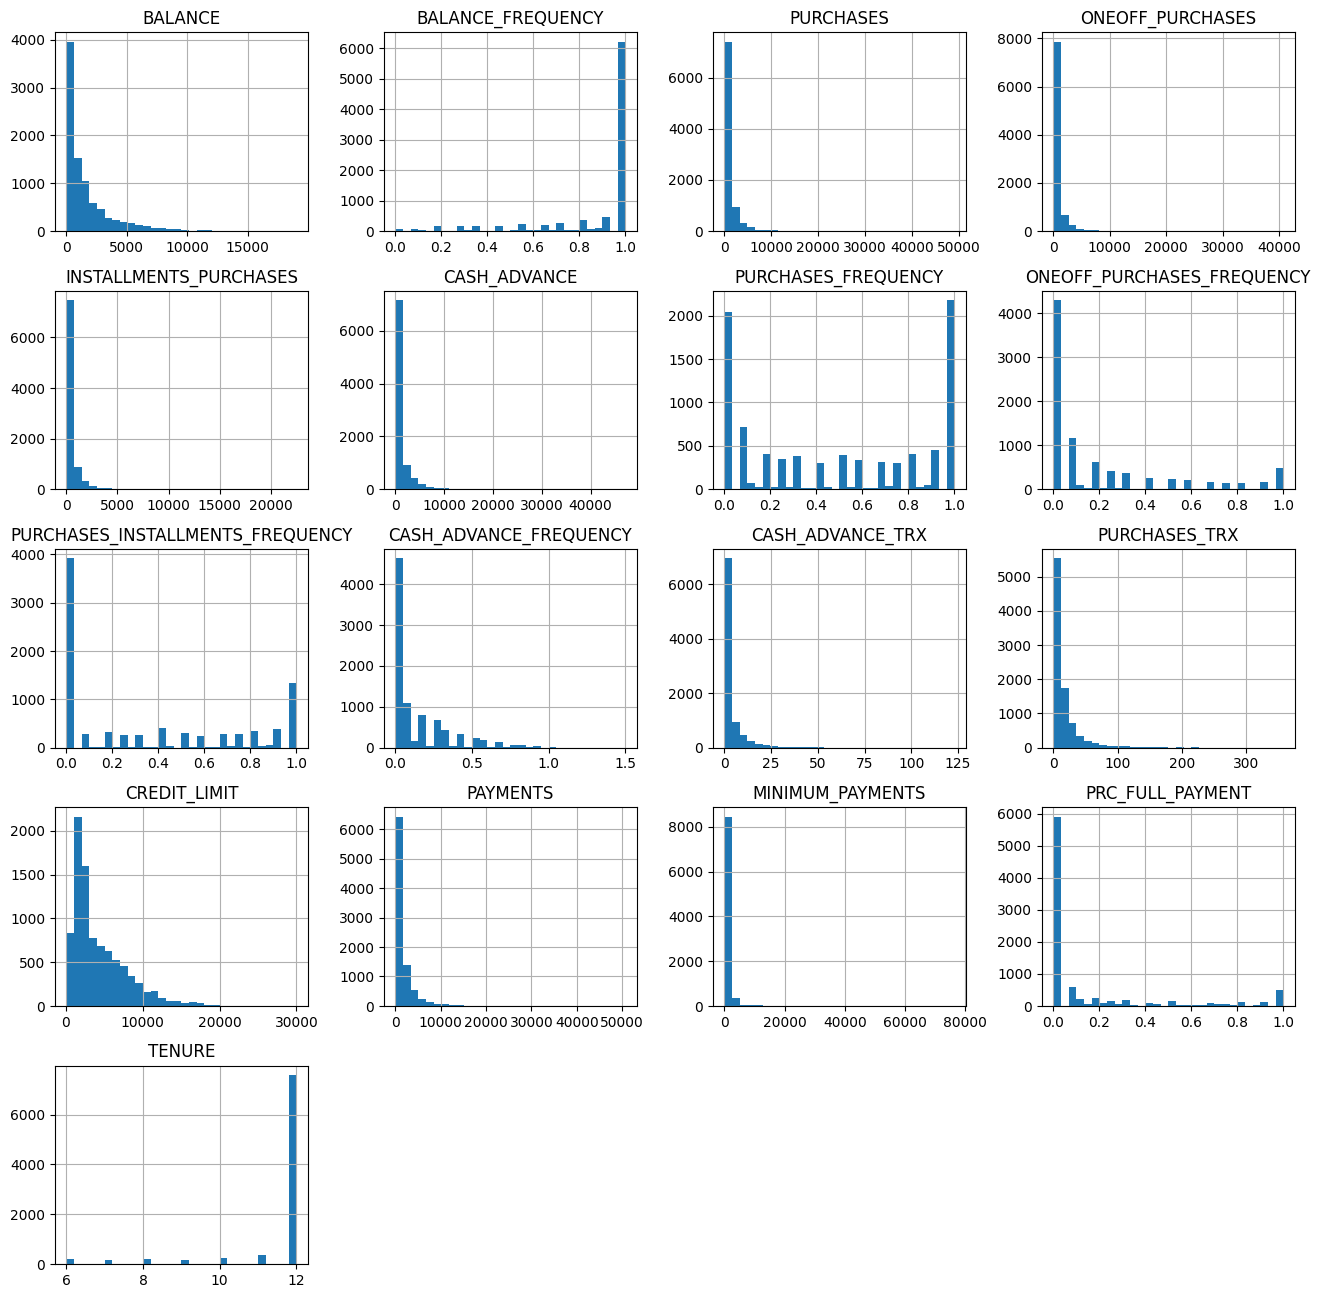

In [13]:
pandas_data.hist(bins=30, figsize=(16, 16))
plt.show()

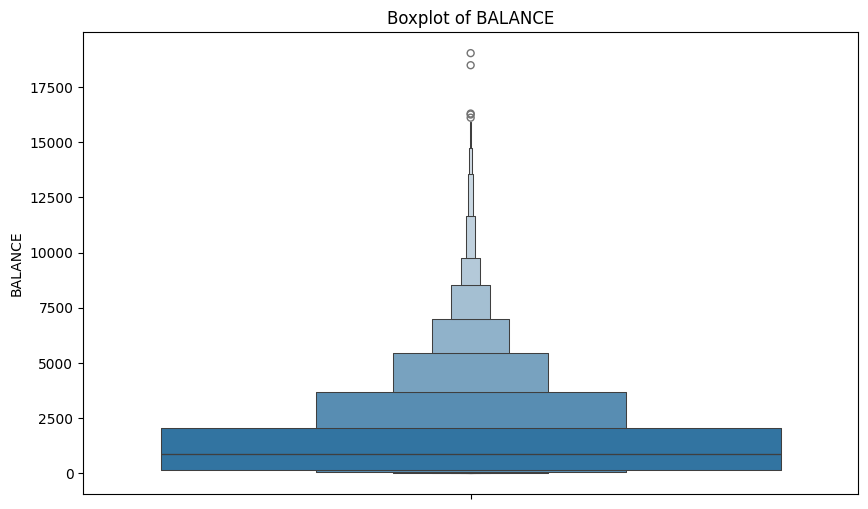

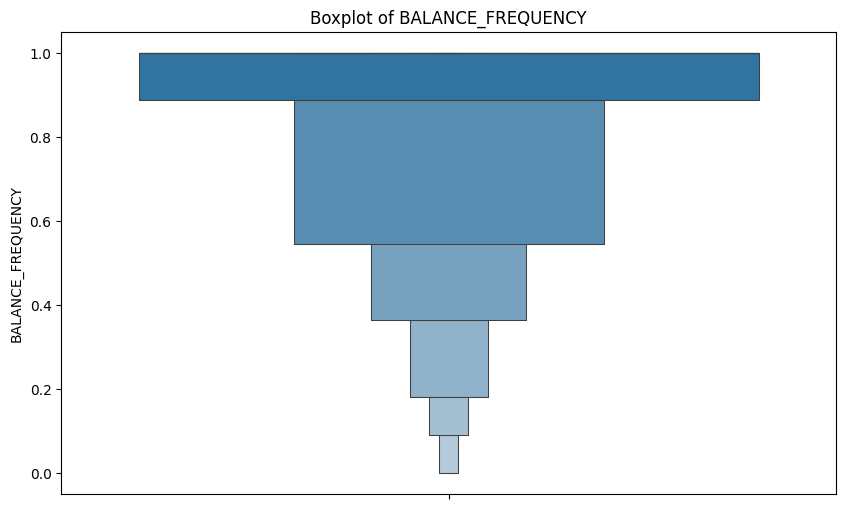

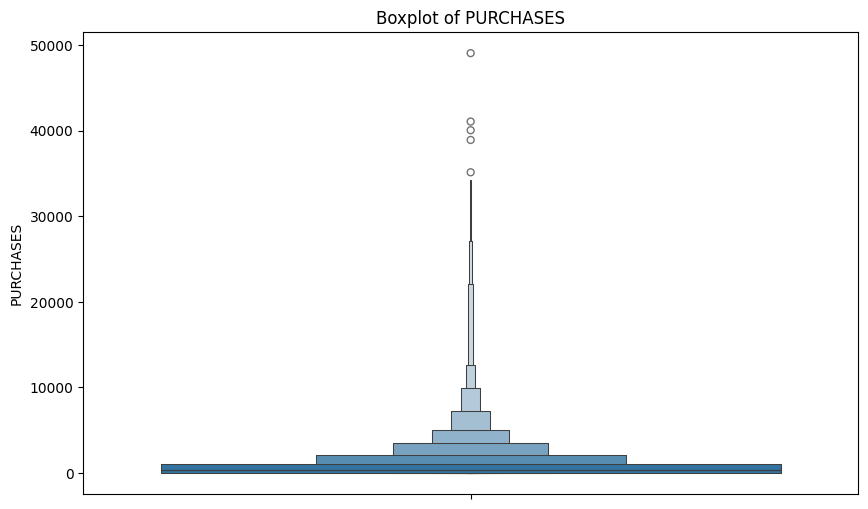

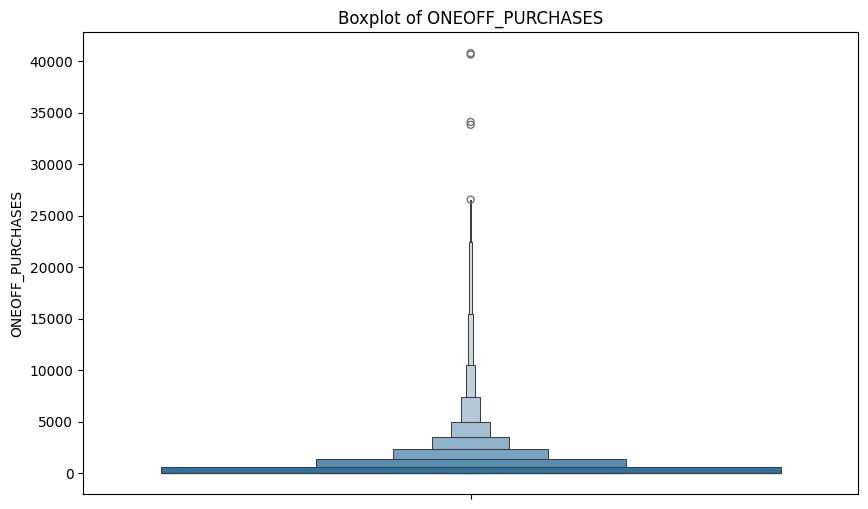

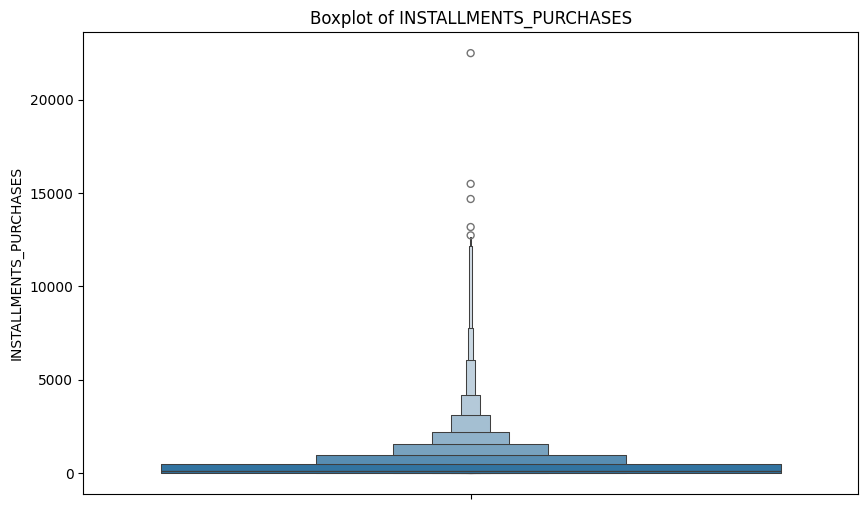

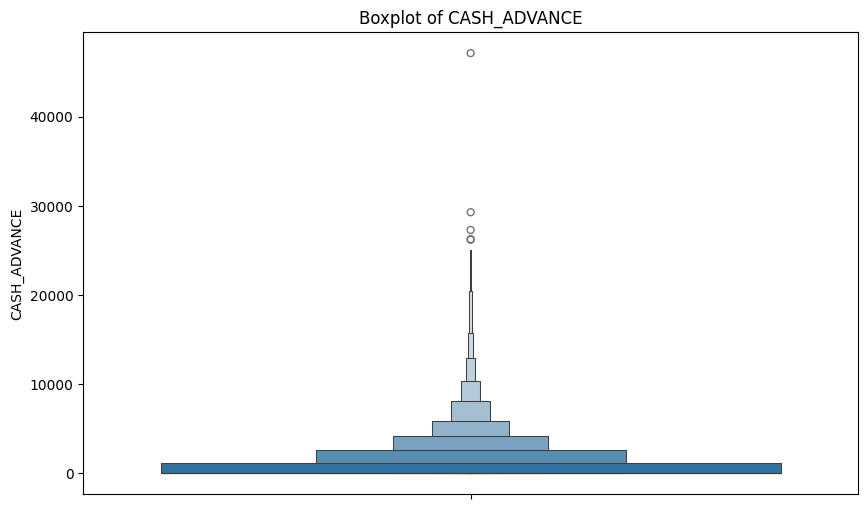

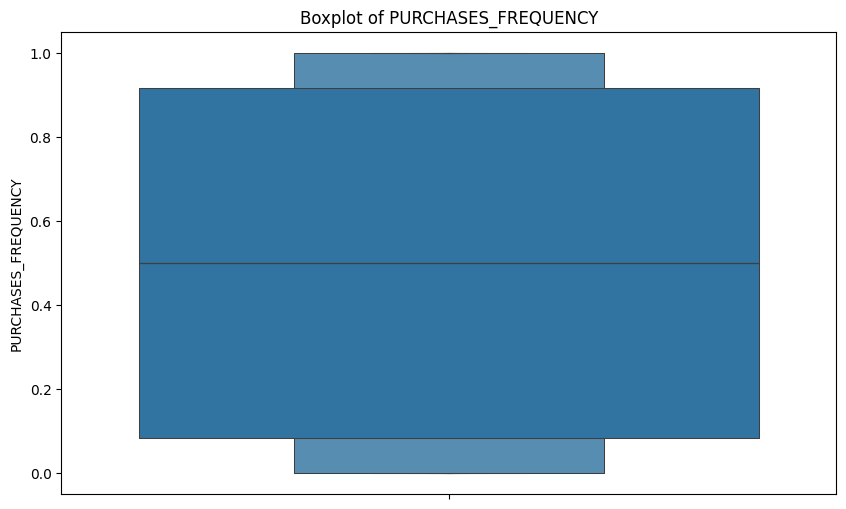

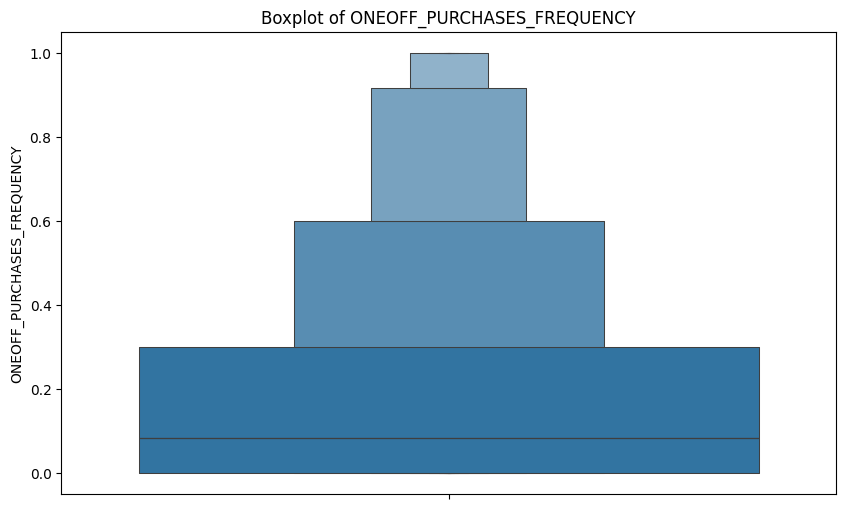

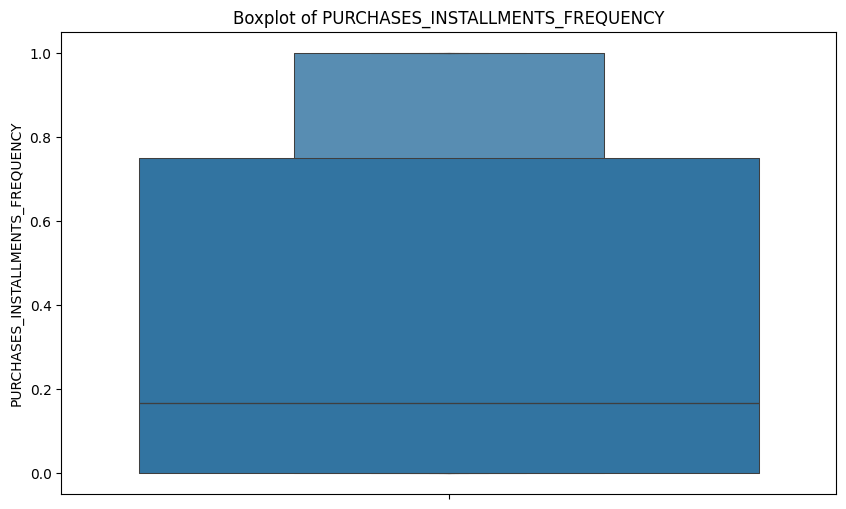

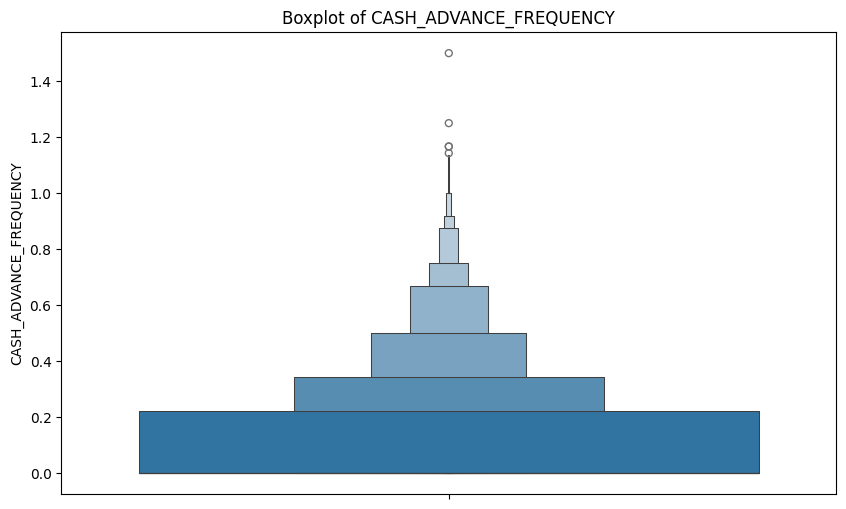

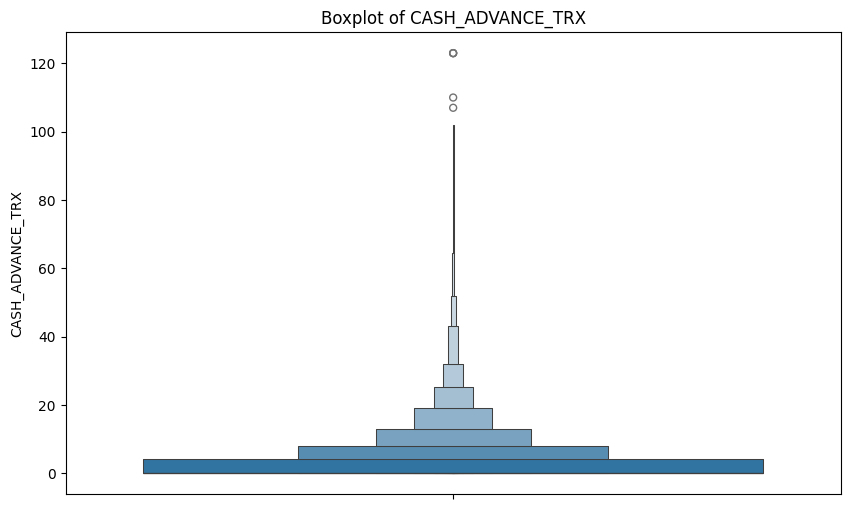

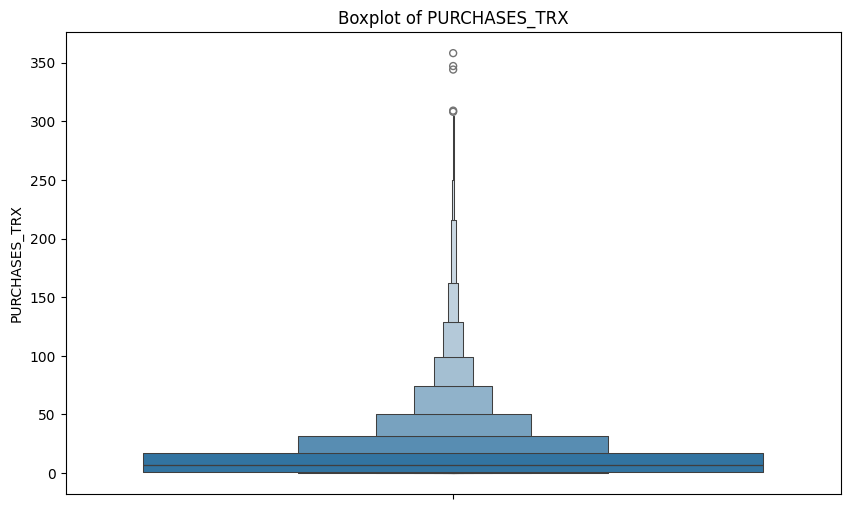

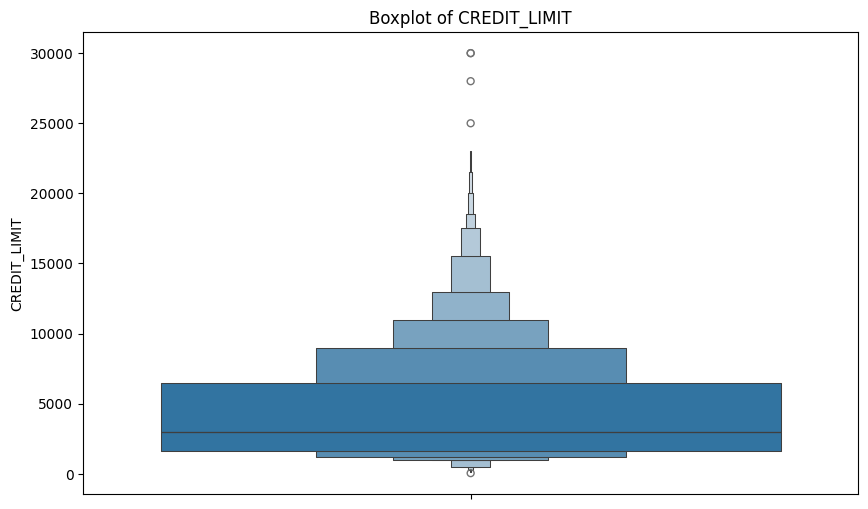

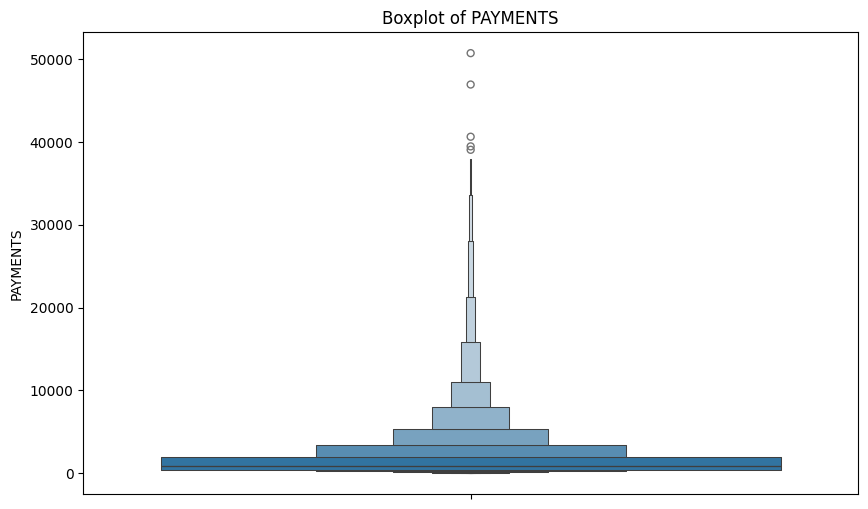

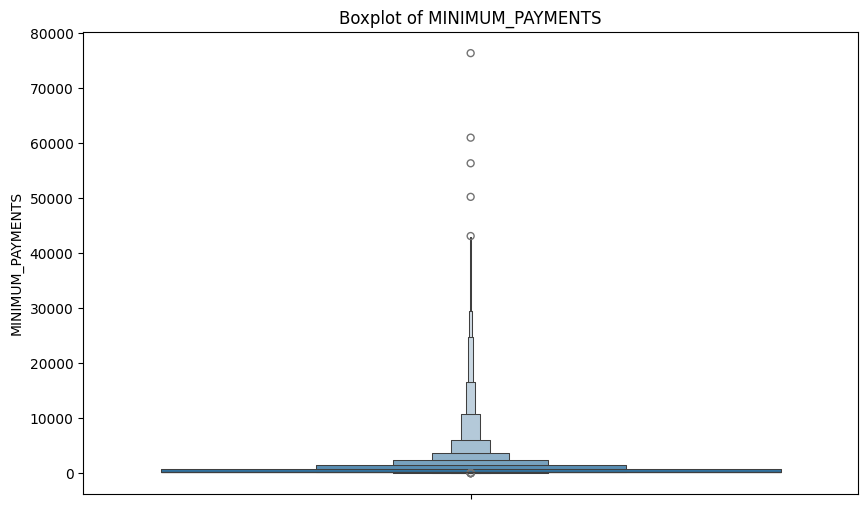

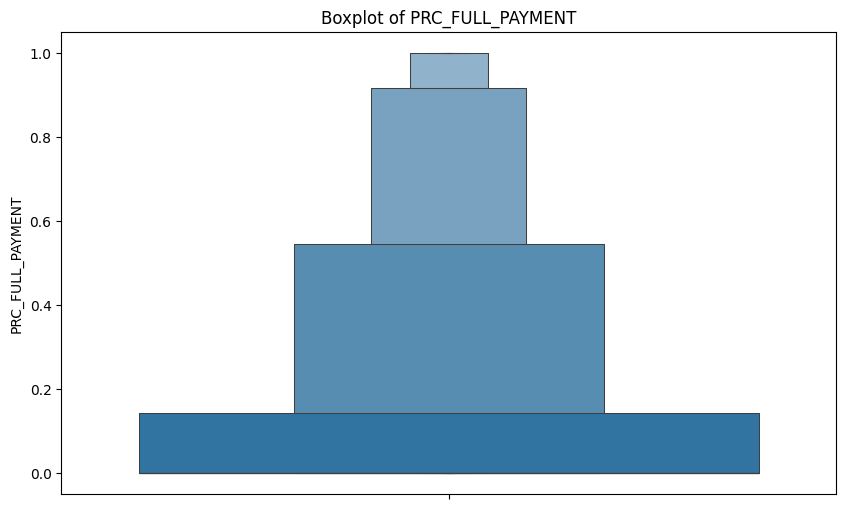

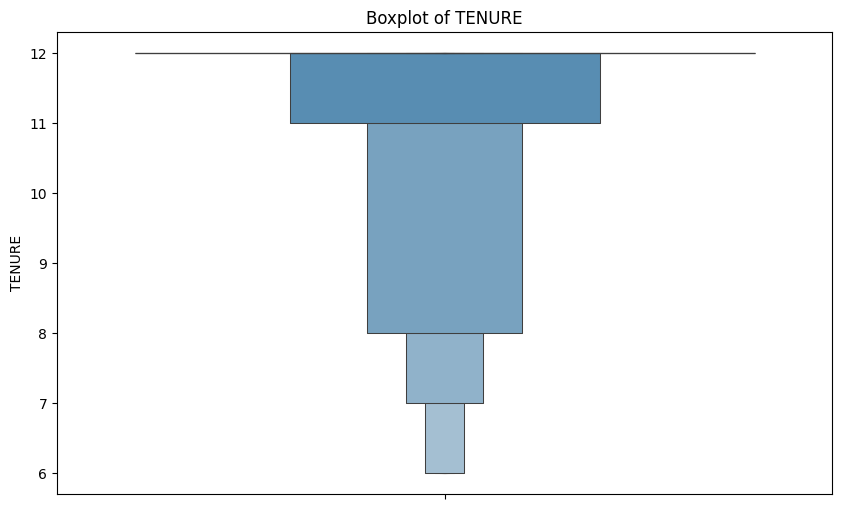

In [14]:
# Check outliers in numeric cols
for col in numeric_cols:
    plt.figure(figsize=(10,6))
    sns.boxenplot(data=pandas_data, y=col)
    plt.title(f"Boxplot of {col}")
    plt.show()

In [15]:
from pyspark.sql.functions import variance

feature_variances = {
    col: data_filled.select(variance(col)).collect()[0][0]
    for col in numeric_cols
}
print("Feature Variances:", feature_variances)

Feature Variances: {'BALANCE': 4332774.965193922, 'BALANCE_FREQUENCY': 0.056123506488064724, 'PURCHASES': 4565208.191109015, 'ONEOFF_PURCHASES': 2755227.898456022, 'INSTALLMENTS_PURCHASES': 817827.4265589601, 'CASH_ADVANCE': 4398096.32549728, 'PURCHASES_FREQUENCY': 0.1610984768435828, 'ONEOFF_PURCHASES_FREQUENCY': 0.08900440778990083, 'PURCHASES_INSTALLMENTS_FREQUENCY': 0.1579647376245586, 'CASH_ADVANCE_FREQUENCY': 0.04004856999408123, 'CASH_ADVANCE_TRX': 46.575803182653246, 'PURCHASES_TRX': 617.9027192701543, 'CREDIT_LIMIT': 13240436.350965623, 'PAYMENTS': 8381394.15654241, 'MINIMUM_PAYMENTS': 5447947.853828861, 'PRC_FULL_PAYMENT': 0.08555577979746501, 'TENURE': 1.7911292482353518}


In [16]:
selected_features = [feature for feature, _ in sorted(feature_variances.items(), key=lambda x: x[1], reverse=True)[:4]]
print("Top 4 selected features based on variance:", selected_features)

Top 4 selected features based on variance: ['CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PURCHASES']


## Feature scaling

In [17]:
from pyspark.ml.feature import RobustScaler
assembler = VectorAssembler(inputCols=selected_features, outputCol="numeric_features")
assembled_data = assembler.transform(data_filled)

robust_scaler = RobustScaler(inputCol="numeric_features", outputCol="scaled_features")
scaled_data = robust_scaler.fit(assembled_data).transform(assembled_data)

scaled_data.select("scaled_features").show(5, truncate=False)

+--------------------------------------------------------------------------------+
|scaled_features                                                                 |
+--------------------------------------------------------------------------------+
|[0.20408163265306123,0.1332530229575578,0.22609572954803392,0.08944141306182146]|
|[1.4285714285714286,2.709295593020977,1.7378819715803309,0.0]                   |
|[1.5306122448979593,0.4107602469202408,1.0166054626056313,0.7248785884382442]   |
|[1.5306122448979593,0.0,0.2740893577454386,1.4053739851118487]                  |
|[0.2448979591836735,0.447914887474346,0.39671950267174216,0.015000656278712195] |
+--------------------------------------------------------------------------------+
only showing top 5 rows



### Reason for Selecting `RobustScaler`
I chose `RobustScaler` because it effectively handles outliers by scaling data using the interquartile range (IQR). This prevents extreme values from influencing the clustering process, making it more reliable. It also standardizes numeric features with varying ranges, which is essential for clustering algorithms that rely on distance metrics like K-Means.


## PCA to reduce dimension

In [18]:
from pyspark.ml.feature import PCA
from pyspark.sql.functions import col

# Apply PCA to reduce dimensions to 2D
pca = PCA(k=2, inputCol="scaled_features", outputCol="pca_features")
pca_model = pca.fit(scaled_data)
pca_data = pca_model.transform(scaled_data)

# Verify PCA output
pca_data.select("pca_features").show(5, truncate=False)

25/01/27 11:49:17 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/01/27 11:49:17 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


+-----------------------------------------+
|pca_features                             |
+-----------------------------------------+
|[-0.2532779772715342,0.14693724939870645]|
|[-2.0587495769491864,1.731816620872755]  |
|[-1.1695558431485356,0.849600519641968]  |
|[-0.4550736667261604,1.176822741271807]  |
|[-0.4502852838151935,0.28236976159178306]|
+-----------------------------------------+
only showing top 5 rows



## Select clustering algorithm

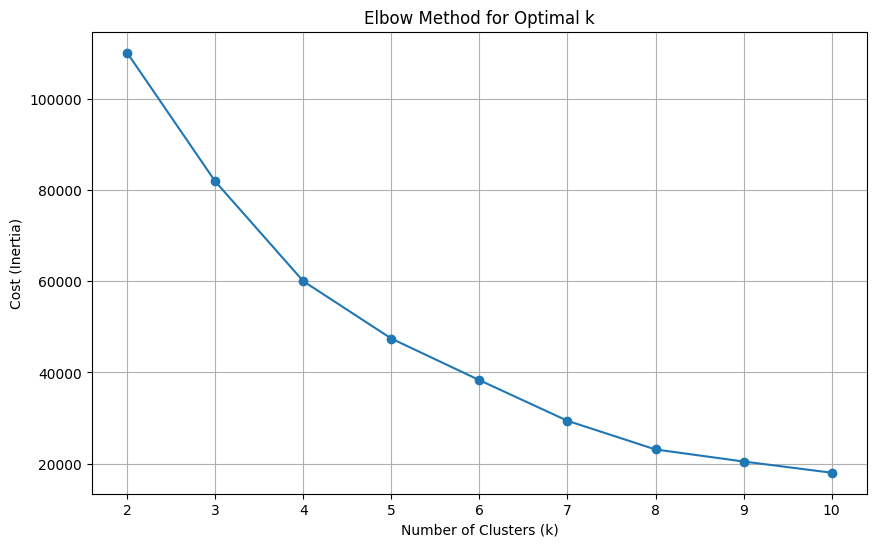

In [19]:
# Find the best k
from pyspark.ml.clustering import KMeans

# Find the best k
costs = []
ks = range(2, 11)

for k in ks:
    kmeans = KMeans(featuresCol="pca_features", predictionCol="cluster", k=k, seed=42)
    kmeans_model = kmeans.fit(pca_data)
    cost = kmeans_model.summary.trainingCost
    costs.append(cost)

# Plot the Elbow Curve
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(ks, costs, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Cost (Inertia)")
plt.xticks(ks)
plt.grid()
plt.show()

In [20]:
optimal_k = 3
kmeans = KMeans(featuresCol="pca_features", predictionCol="cluster", k=optimal_k, seed=42)
kmeans_model = kmeans.fit(pca_data)

clustered_data = kmeans_model.transform(pca_data)
clustered_data.select("pca_features", "cluster").show(5)

+--------------------+-------+
|        pca_features|cluster|
+--------------------+-------+
|[-0.2532779772715...|      0|
|[-2.0587495769491...|      0|
|[-1.1695558431485...|      0|
|[-0.4550736667261...|      0|
|[-0.4502852838151...|      0|
+--------------------+-------+
only showing top 5 rows



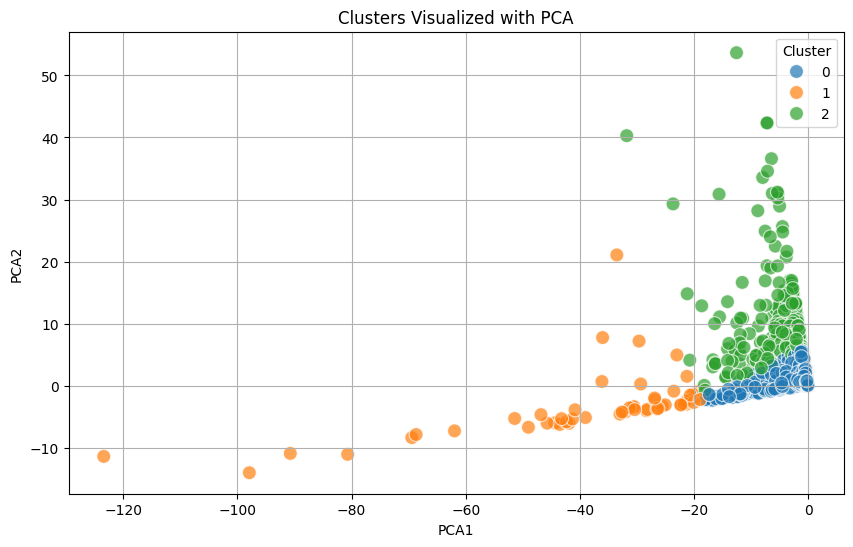

In [21]:

from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, DoubleType

# Convert the PCA Vector into an Array
vector_to_array_udf = udf(lambda vector: vector.toArray().tolist(), ArrayType(DoubleType()))
clustered_data = clustered_data.withColumn("pca_array", vector_to_array_udf(col("pca_features")))

# Extract PCA components into individual columns
clustered_data = clustered_data.withColumn("PCA1", col("pca_array").getItem(0)) \
                               .withColumn("PCA2", col("pca_array").getItem(1))

# Convert to Pandas for Visualization
pandas_clustered_data = clustered_data.select("PCA1", "PCA2", "cluster").toPandas()

# Plot the Clusters
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=pandas_clustered_data,
    x="PCA1", y="PCA2",
    hue="cluster", palette="tab10", s=100, alpha=0.7
)
plt.title("Clusters Visualized with PCA")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend(title="Cluster")
plt.grid()
plt.show()

### Why k=3 is better:
- **Clear Separation**: The clusters for k=3 show a good separation without excessive overlap.
- **Interpretability**: With three clusters, it’s easier to interpret and analyze the characteristics of each group compared to four or two clusters.
- **Elbow Method Validation**: If the elbow method also suggests k=3, it confirms this choice as optimal.

## Evaluate

In [22]:
from pyspark.ml.evaluation import ClusteringEvaluator

# Evaluate clustering by Silhouette Score
evaluator = ClusteringEvaluator(featuresCol="pca_features", predictionCol="cluster", metricName="silhouette")
silhouette_score = evaluator.evaluate(clustered_data)

print(f"Silhouette Score: {silhouette_score:.2f}")

Silhouette Score: 0.89


- Silhouette Score: 0.89 indicates high-quality clustering with well-separated clusters and strong cohesion.
- Interpretation: The clusters are compact and distinct, effectively grouping the data.
- Conclusion: The clustering model is robust, and the chosen k is likely appropriate.